# 06_benchmark_analysis.ipynb - combine, ROC, CM, McNemar

# Cell 0 - perf env

In [1]:
import os
os.environ.setdefault("OMP_NUM_THREADS", "8")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "8")
os.environ.setdefault("MKL_NUM_THREADS", "8")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "8")
'8'

'8'

# Cell 1 - imports & load

In [2]:
from pathlib import Path
import json
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    f1_score,
    average_precision_score,
    balanced_accuracy_score,
    matthews_corrcoef,
    classification_report,
    log_loss,
    brier_score_loss,
)

warnings.filterwarnings("ignore")

ROOT = Path(".")
PROCESSED = ROOT / "data/processed"
RESULTS = ROOT / "results"
for sub in ["metrics", "stats", "plots", "logs"]:
    (RESULTS / sub).mkdir(parents=True, exist_ok=True)

SEED = 23
np.random.seed(SEED)
pnp.random.seed(SEED)

class RunJournal:
    def __init__(self):
        self.events = []
        self.timing = {}

    def log(self, step, status, message, **extra):
        row = {
            "ts": time.strftime("%Y-%m-%d %H:%M:%S"),
            "step": step,
            "status": status,
            "message": message,
        }
        row.update(extra)
        self.events.append(row)
        tag = {
            "ok": "[OK]",
            "warn": "[WARN]",
            "fail": "[FAIL]",
        }.get(status, "[INFO]")
        print(f"{tag} [{step}] {message}")

    def record_timing(self, step, seconds):
        self.timing[step] = round(float(seconds), 4)

    def save(self, base: Path):
        df = pd.DataFrame(self.events)
        if not df.empty:
            md = ["| ts | step | status | message |", "|---|---|---|---|"]
            for _, row in df.iterrows():
                md.append(f"| {row.ts} | {row.step} | {row.status} | {row.message} |")
            base.with_suffix(".md").write_text("\n".join(md), encoding="utf-8")
            base.with_suffix(".json").write_text(df.to_json(orient="records", indent=2), encoding="utf-8")
        if self.timing:
            timing_payload = {"timing": self.timing, "generated_at": time.strftime("%Y-%m-%d %H:%M:%S")}
            timing_path = RESULTS / "metrics" / "benchmark_analysis_run_report.json"
            timing_path.write_text(json.dumps(timing_payload, indent=2), encoding="utf-8")

J = RunJournal()

# --- Load encodings and splits (handles legacy filenames) ---
enc_path = PROCESSED / "encodings_all.npz" if (PROCESSED / "encodings_all.npz").exists() else PROCESSED / "encodings.npz"
spl_path = PROCESSED / "splits_pooled.json" if (PROCESSED / "splits_pooled.json").exists() else PROCESSED / "splits.json"

data = np.load(enc_path, allow_pickle=True)
with open(spl_path) as fh:
    SPL = json.load(fh)
J.log("load", "ok", f"Loaded {enc_path.name} and {spl_path.name}")

y = data["y"].astype(int)
X_kmer = data["kmer"].astype(np.float32)
X_onehot = data["onehot"].astype(np.float32)
tr = np.array(SPL["train"])  # train indices
va = np.array(SPL["val"])    # validation indices
te = np.array(SPL["test"])   # test indices
J.log("splits", "ok", f"train={len(tr)}, val={len(va)}, test={len(te)}, pos_rate={y.mean():.4f}")

[OK] [load] Loaded encodings_all.npz and splits_pooled.json
[OK] [splits] train=12336, val=4112, test=4112, pos_rate=0.8654


# Cell 2 - metric pack

In [3]:
def _safe_auc(y_true, y_prob):
    try: return roc_auc_score(y_true, y_prob)
    except Exception: return float("nan")

def _safe_ap(y_true, y_prob):
    try: return average_precision_score(y_true, y_prob)
    except Exception: return float("nan")

def _extended_metrics(y_true, y_prob, y_pred, thr):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    bal = balanced_accuracy_score(y_true, y_pred)
    tnr = tn / (tn + fp) if (tn + fp) else float("nan")  # specificity
    mcc = matthews_corrcoef(y_true, y_pred) if len(np.unique(y_true))==2 else float("nan")
    return dict(acc=acc, prec=prec, rec=rec, f1=f1,
                roc_auc=_safe_auc(y_true, y_prob),
                pr_auc=_safe_ap(y_true, y_prob),
                balanced_acc=bal, specificity=tnr, mcc=mcc, thr=float(thr)), cm

def pack_metrics(y_true, y_prob, split, model, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    m, cm = _extended_metrics(y_true, y_prob, y_pred, thr)
    m.update(dict(model=model, split=split))
    return m, y_pred, cm

# Cell 3 - Classical baselines

In [4]:
# SVM on k-mer embeddings
start = time.perf_counter()
svm_kmer = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    SVC(C=5.0, kernel="rbf", gamma="scale", probability=True, class_weight="balanced", random_state=0),
)
svm_kmer.fit(X_kmer[tr], y[tr])

p_tr = svm_kmer.predict_proba(X_kmer[tr])[:, 1]
p_va = svm_kmer.predict_proba(X_kmer[va])[:, 1]
p_te = svm_kmer.predict_proba(X_kmer[te])[:, 1]

thr_grid = np.linspace(0.1, 0.9, 33)
thr_k = max(
    ((thr, f1_score(y[va], (p_va >= thr).astype(int), zero_division=0)) for thr in thr_grid),
    key=lambda item: item[1],
)[0]

m1_tr, y1_tr, cm1_tr = pack_metrics(y[tr], p_tr, "train", "SVM_kmer", thr=thr_k)
m1_va, y1_va, cm1_va = pack_metrics(y[va], p_va, "val", "SVM_kmer", thr=thr_k)
m1_te, y1_te, cm1_te = pack_metrics(y[te], p_te, "test", "SVM_kmer", thr=thr_k)

elapsed = time.perf_counter() - start
J.record_timing("svm_kmer", elapsed)
J.log(
    "svm_kmer",
    "ok",
    f"Val-opt thr={thr_k:.2f}; test F1={m1_te['f1']:.3f}, AUC={m1_te['roc_auc']:.3f}, PR-AUC={m1_te['pr_auc']:.3f} (elapsed={elapsed:.2f}s)",
)

# SVM on flattened one-hot encodings
start = time.perf_counter()
X_flat = X_onehot.reshape(len(X_onehot), -1).astype(np.float32)
svm_1h = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    SVC(C=2.0, kernel="rbf", gamma="scale", probability=True, class_weight="balanced", random_state=0),
)
svm_1h.fit(X_flat[tr], y[tr])

q_tr = svm_1h.predict_proba(X_flat[tr])[:, 1]
q_va = svm_1h.predict_proba(X_flat[va])[:, 1]
q_te = svm_1h.predict_proba(X_flat[te])[:, 1]

thr_1h = max(
    ((thr, f1_score(y[va], (q_va >= thr).astype(int), zero_division=0)) for thr in thr_grid),
    key=lambda item: item[1],
)[0]

m2_tr, y2_tr, cm2_tr = pack_metrics(y[tr], q_tr, "train", "SVM_onehot", thr=thr_1h)
m2_va, y2_va, cm2_va = pack_metrics(y[va], q_va, "val", "SVM_onehot", thr=thr_1h)
m2_te, y2_te, cm2_te = pack_metrics(y[te], q_te, "test", "SVM_onehot", thr=thr_1h)

elapsed = time.perf_counter() - start
J.record_timing("svm_onehot", elapsed)
J.log(
    "svm_onehot",
    "ok",
    f"Val-opt thr={thr_1h:.2f}; test F1={m2_te['f1']:.3f}, AUC={m2_te['roc_auc']:.3f}, PR-AUC={m2_te['pr_auc']:.3f} (elapsed={elapsed:.2f}s)",
)


[OK] [svm_kmer] Val-opt thr=0.40; test F1=0.954, AUC=0.802, PR-AUC=0.939 (elapsed=24.45s)
[OK] [svm_onehot] Val-opt thr=0.30; test F1=0.954, AUC=0.842, PR-AUC=0.956 (elapsed=680.91s)


# Cell 4 - QSVM (load kernels or rebuild tiny)

In [5]:
K_trtr_path = RESULTS / "kernels" / "K_trtr.npy"
K_vatr_path = RESULTS / "kernels" / "K_vatr.npy"
K_tetr_path = RESULTS / "kernels" / "K_tetr.npy"

thr_grid = np.linspace(0.1, 0.9, 33)

start_total = time.perf_counter()

def _align_y(y_full, idx, n_rows):
    """Return y_full[idx] truncated to n_rows (to match Gram rows)."""
    y_slice = y_full[idx]
    return y_slice[:n_rows]

if K_trtr_path.exists() and K_vatr_path.exists() and K_tetr_path.exists():
    start_load = time.perf_counter()
    K_trtr = np.load(K_trtr_path)
    K_vatr = np.load(K_vatr_path)
    K_tetr = np.load(K_tetr_path)
    load_elapsed = time.perf_counter() - start_load
    J.record_timing("qsvm_kernel_load", load_elapsed)

    tr_override_path = RESULTS / "kernels" / "train_indices.npy"
    if tr_override_path.exists():
        try:
            tr_override = np.load(tr_override_path)
            if K_trtr.shape[0] == len(tr_override):
                ytr_sel = y[tr_override]
            else:
                ytr_sel = y[tr][:K_trtr.shape[0]]
                J.log("qsvm_kernel", "warn", "train_indices length mismatch; falling back to split order")
        except Exception as exc:
            ytr_sel = y[tr][:K_trtr.shape[0]]
            J.log("qsvm_kernel", "warn", f"Could not load train_indices.npy ({exc}); using split order")
    else:
        ytr_sel = y[tr][:K_trtr.shape[0]]

    yva_sel = y[va][:K_vatr.shape[0]]
    yte_sel = y[te][:K_tetr.shape[0]]
    J.log(
        "qsvm_kernel",
        "ok",
        f"Loaded Gram matrices: train={K_trtr.shape}, val={K_vatr.shape}, test={K_tetr.shape} (elapsed={load_elapsed:.2f}s)",
    )
else:
    J.log("qsvm_kernel", "warn", "Kernel cache missing; rebuilding small kernel with default.qubit.")
    D = 8
    pca = PCA(n_components=D, random_state=23)
    Xtr_p = pca.fit_transform(X_kmer[tr])
    Xva_p = pca.transform(X_kmer[va])
    Xte_p = pca.transform(X_kmer[te])
    to_angle = lambda X: (np.clip(X, -3, 3) / 3.0) * np.pi
    Xtr_p, Xva_p, Xte_p = to_angle(Xtr_p), to_angle(Xva_p), to_angle(Xte_p)

    dev = qml.device("default.qubit", wires=D, shots=None)

    def U(x):
        qml.AngleEmbedding(x, wires=range(D), rotation="Y")
        for wire in range(D):
            qml.CZ(wires=[wire, (wire + 1) % D])

    @qml.qnode(dev)
    def kcirc(a, b):
        U(a)
        qml.adjoint(U)(b)
        return qml.expval(qml.Projector([0] * D, wires=range(D)))

    def gram(A, B):
        K = np.zeros((len(A), len(B)), dtype=float)
        for i in range(len(A)):
            for j in range(len(B)):
                K[i, j] = kcirc(A[i], B[j])
        return K

    start_build = time.perf_counter()
    K_trtr = gram(Xtr_p, Xtr_p)
    K_vatr = gram(Xva_p, Xtr_p)
    K_tetr = gram(Xte_p, Xtr_p)
    build_elapsed = time.perf_counter() - start_build
    J.record_timing("qsvm_kernel_build", build_elapsed)

    ytr_sel = y[tr]
    yva_sel = y[va]
    yte_sel = y[te]
    J.log(
        "qsvm_kernel",
        "ok",
        f"Built Gram matrices: train={K_trtr.shape}, val={K_vatr.shape}, test={K_tetr.shape} (elapsed={build_elapsed:.2f}s)",
    )

start_fit = time.perf_counter()
clf_q = SVC(C=5.0, kernel="precomputed", probability=True, class_weight="balanced", random_state=0)
clf_q.fit(K_trtr, ytr_sel)
fit_elapsed = time.perf_counter() - start_fit
J.record_timing("qsvm_kernel_fit", fit_elapsed)

start_predict = time.perf_counter()
r_tr = clf_q.predict_proba(K_trtr)[:, 1]
r_va = clf_q.predict_proba(K_vatr)[:, 1]
r_te = clf_q.predict_proba(K_tetr)[:, 1]
predict_elapsed = time.perf_counter() - start_predict
J.record_timing("qsvm_kernel_predict", predict_elapsed)

n_tr, n_va, n_te = len(r_tr), len(r_va), len(r_te)
y_tr_use = ytr_sel[:n_tr]
y_va_use = yva_sel[:n_va]
y_te_use = yte_sel[:n_te]

if (len(yva_sel) != n_va) or (len(yte_sel) != n_te):
    J.log(
        "qsvm_align",
        "warn",
        f"Aligned labels to kernel rows: val {len(yva_sel)}->{n_va}, test {len(yte_sel)}->{n_te}",
    )

thr_q = 0.5
best_f1 = -1.0
for thr in thr_grid:
    f1_val = f1_score(y_va_use, (r_va >= thr).astype(int), zero_division=0)
    if f1_val > best_f1:
        best_f1 = float(f1_val)
        thr_q = float(thr)

m3_tr, y3_tr, cm3_tr = pack_metrics(y_tr_use, r_tr, "train", "QSVM_kernel", thr=thr_q)
m3_va, y3_va, cm3_va = pack_metrics(y_va_use, r_va, "val", "QSVM_kernel", thr=thr_q)
m3_te, y3_te, cm3_te = pack_metrics(y_te_use, r_te, "test", "QSVM_kernel", thr=thr_q)

elapsed_total = time.perf_counter() - start_total
J.record_timing("qsvm_kernel_total", elapsed_total)
J.log(
    "qsvm_fit",
    "ok",
    f"Val-opt thr={thr_q:.2f}; test F1={m3_te['f1']:.3f}, AUC={m3_te['roc_auc']:.3f}, PR-AUC={m3_te['pr_auc']:.3f} (elapsed={elapsed_total:.2f}s)",
)


[OK] [qsvm_kernel] Loaded Gram matrices: train=(300, 300), val=(4112, 300), test=(4112, 300) (elapsed=0.01s)
[OK] [qsvm_fit] Val-opt thr=0.50; test F1=0.928, AUC=0.650, PR-AUC=0.907 (elapsed=0.16s)


# Cell 5 - VQC eval (load weights; val-optimal thr)

In [6]:
# Optional ingestion of stored metrics (e.g., from VQC notebook)
vqc_metrics_path = RESULTS / "metrics" / "vqc_metrics.csv"
vqc_prob_path = RESULTS / "roc_cache" / "probs_vqc.npy"

m4_tr = m4_va = m4_te = None
s_tr = s_va = s_te = None

if vqc_metrics_path.exists():
    vqc_df = pd.read_csv(vqc_metrics_path)
    for split_name, target in [("train", "m4_tr"), ("val", "m4_va"), ("test", "m4_te")]:
        subset = vqc_df[vqc_df["split"].str.lower() == split_name]
        if not subset.empty:
            globals()[target] = subset.iloc[-1].to_dict()
    J.log("vqc_metrics", "ok", "Loaded stored VQC metrics from metrics/vqc_metrics.csv")
else:
    J.log("vqc_metrics", "warn", "No stored VQC metrics found; skipping VQC entries")

if vqc_prob_path.exists():
    s_te = np.load(vqc_prob_path).astype(float)
    if len(s_te.shape) > 1:
        s_te = s_te[:, -1]
    J.log("vqc_probs", "ok", "Loaded VQC test probabilities from roc_cache/probs_vqc.npy")
else:
    J.log("vqc_probs", "warn", "No VQC probability cache detected; calibration for VQC will be skipped")


[OK] [vqc_metrics] Loaded stored VQC metrics from metrics/vqc_metrics.csv
[WARN] [vqc_probs] No VQC probability cache detected; calibration for VQC will be skipped


# Cell 6 - save combined + ROC/CM caches

In [7]:
# 1) Combine metrics (only those that exist)
rows = []
for trio in [
    ('m1_tr','m1_va','m1_te'),   # SVM_kmer
    ('m2_tr','m2_va','m2_te'),   # SVM_onehot
    ('m3_tr','m3_va','m3_te'),   # QSVM_kernel
    ('m4_tr','m4_va','m4_te'),   # VQC (may be absent)
]:
    for name in trio:
        if name in locals() and isinstance(locals()[name], dict):
            rows.append(locals()[name])

if not rows:
    raise RuntimeError("No metric rows available to combine; upstream cells must compute metrics first.")

df_combined = pd.DataFrame(rows)
df_combined.to_csv(RESULTS/"metrics/combined.csv", index=False)

# 2) Save ROC probability caches (test) - only if arrays exist & lengths match y[test]
ROC_DIR = RESULTS/"roc_cache"; ROC_DIR.mkdir(parents=True, exist_ok=True)
np.save(ROC_DIR/"y_test.npy", y[te])  # always save ground truth

def _save_prob(name, arr):
    if arr is None: 
        J.log("roc_cache", "warn", f"Skip {name}: probabilities are None.")
        return
    if len(arr) != len(y[te]):
        J.log("roc_cache", "warn", f"Skip {name}: length mismatch probs={len(arr)} vs y_test={len(y[te])}.")
        return
    np.save(ROC_DIR/f"probs_{name}.npy", arr)
    J.log("roc_cache", "ok", f"Saved probs_{name}.npy")

# Model probability arrays (if present)
p_te_safe = globals().get("p_te")   # SVM_kmer
q_te_safe = globals().get("q_te")   # SVM_onehot
r_te_safe = globals().get("r_te")   # QSVM_kernel
s_te_safe = globals().get("s_te")   # VQC (may be missing)

_save_prob("svm_kmer",    p_te_safe)
_save_prob("svm_onehot",  q_te_safe)
_save_prob("qsvm_kernel", r_te_safe)
_save_prob("vqc",         s_te_safe)

# 3) Save CM caches (binary predictions at model-specific best thr)
CM_DIR = RESULTS/"cm_cache"; CM_DIR.mkdir(parents=True, exist_ok=True)
(Path(CM_DIR/"y_true.json")).write_text(json.dumps(y[te].astype(int).tolist()))


if r_te_safe is not None and hasattr(r_te_safe, "__len__") and len(r_te_safe) != len(y[te]):
    (Path(CM_DIR / "y_true_qsvm.json")).write_text(json.dumps(y[te][:len(r_te_safe)].astype(int).tolist()))
if s_te_safe is not None and hasattr(s_te_safe, "__len__") and len(s_te_safe) != len(y[te]):
    (Path(CM_DIR / "y_true_vqc.json")).write_text(json.dumps(y[te][:len(s_te_safe)].astype(int).tolist()))

def _write_preds(name, probs, thr):
    if probs is None or thr is None:
        J.log("cm_cache", "warn", f"Skip y_pred_{name}: missing probs or threshold.")
        return
    if len(probs) != len(y[te]):
        J.log("cm_cache", "warn", f"Skip y_pred_{name}: length mismatch {len(probs)} vs {len(y[te])}.")
        return
    (Path(CM_DIR)/f"y_pred_{name}.json").write_text(json.dumps((probs >= thr).astype(int).tolist()))
    J.log("cm_cache", "ok", f"Saved y_pred_{name}.json (thr={thr:.3f})")

_write_preds("svm_kmer",    p_te_safe, globals().get("m1_te", {}).get("thr"))
_write_preds("svm_onehot",  q_te_safe, globals().get("m2_te", {}).get("thr"))
_write_preds("qsvm_kernel", r_te_safe, globals().get("m3_te", {}).get("thr"))
_write_preds("vqc",         s_te_safe, globals().get("m4_te", {}).get("thr"))

# 4) Persist per-model classification reports (test) for documentation
reports = {}
def _add_report(pretty_name, probs, m_te):
    if probs is None or not isinstance(m_te, dict) or "thr" not in m_te:
        J.log("reports", "warn", f"Skip report for {pretty_name}: missing probs or threshold.")
        return
    if len(probs) != len(y[te]):
        J.log("reports", "warn", f"Skip report for {pretty_name}: length mismatch {len(probs)} vs {len(y[te])}.")
        return
    yhat = (probs >= m_te["thr"]).astype(int)
    reports[pretty_name] = classification_report(y[te], yhat, output_dict=True, zero_division=0)

_add_report("SVM_kmer",    p_te_safe, globals().get("m1_te"))
_add_report("SVM_onehot",  q_te_safe, globals().get("m2_te"))
_add_report("QSVM_kernel", r_te_safe, globals().get("m3_te"))
_add_report("VQC",         s_te_safe, globals().get("m4_te"))

with open(RESULTS/"metrics/classification_reports_test.json", "w", encoding="utf-8") as f:
    json.dump(reports, f, indent=2)

# 5) Nice quick view (test split only), if available
try:
    display(df_combined[df_combined["split"]=="test"].sort_values("f1", ascending=False))
except Exception:
    # If split column is missing for any reason, just show all rows
    display(df_combined)


[OK] [roc_cache] Saved probs_svm_kmer.npy
[OK] [roc_cache] Saved probs_svm_onehot.npy
[OK] [roc_cache] Saved probs_qsvm_kernel.npy
[WARN] [roc_cache] Skip vqc: probabilities are None.
[OK] [cm_cache] Saved y_pred_svm_kmer.json (thr=0.400)
[OK] [cm_cache] Saved y_pred_svm_onehot.json (thr=0.300)
[OK] [cm_cache] Saved y_pred_qsvm_kernel.json (thr=0.500)
[WARN] [cm_cache] Skip y_pred_vqc: missing probs or threshold.
[WARN] [reports] Skip report for VQC: missing probs or threshold.


,acc,prec,rec,f1,roc_auc,pr_auc,balanced_acc,specificity,mcc,thr,model,split,tp,tn,fp,fn,support
5,0.917558,0.917315,0.994380,0.954294,0.842139,0.956038,0.708763,0.423146,0.591716,0.30,SVM_onehot,test,NaN,NaN,NaN,NaN,NaN
2,0.916829,0.922956,0.986232,0.953545,0.801506,0.938734,0.728197,0.470163,0.590643,0.40,SVM_kmer,test,NaN,NaN,NaN,NaN,NaN
11,0.865516,0.865516,1.000000,0.927910,0.540335,0.880499,0.500000,0.000000,0.000000,0.05,VQC,test,3559.0,0.0,553.0,0.0,4112.0
8,0.865516,0.866228,0.998876,0.927835,0.649902,0.907219,0.503055,0.007233,0.047301,0.50,QSVM_kernel,test,NaN,NaN,NaN,NaN,NaN


In [8]:
# Build consolidated summary tables for downstream reporting
summary_cols = [
    "model",
    "acc",
    "prec",
    "rec",
    "f1",
    "roc_auc",
    "pr_auc",
    "balanced_acc",
    "specificity",
    "mcc",
    "thr",
]

def _ensure_columns(df, cols):
    out = df.copy()
    for col in cols:
        if col not in out.columns:
            out[col] = np.nan
    return out

if isinstance(df_combined, pd.DataFrame) and not df_combined.empty and "split" in df_combined.columns:
    test_all = df_combined[df_combined["split"].str.lower() == "test"].copy()
else:
    test_all = pd.DataFrame()

scorecard = pd.DataFrame()

if not test_all.empty:
    test_all = _ensure_columns(test_all, summary_cols)
    test_all = test_all.dropna(subset=["model"]).drop_duplicates(subset=["model"], keep="last")
    test_all = test_all.reset_index(drop=True)
    test_all[summary_cols].to_csv(RESULTS / "metrics/summary_test.csv", index=False)

    metrics_focus = [m for m in ["f1", "roc_auc", "pr_auc", "balanced_acc"] if m in test_all.columns]
    scorecard = test_all[["model"] + metrics_focus].copy()
    for metric in metrics_focus:
        vals = scorecard[metric]
        finite_vals = vals.replace([np.inf, -np.inf], np.nan).dropna()
        if finite_vals.empty:
            scorecard[f"{metric}_norm"] = np.nan
        else:
            lo, hi = finite_vals.min(), finite_vals.max()
            if hi > lo:
                scorecard[f"{metric}_norm"] = (vals - lo) / (hi - lo)
            else:
                scorecard[f"{metric}_norm"] = 0.0

    weight_map = {"f1": 0.4, "roc_auc": 0.3, "pr_auc": 0.2, "balanced_acc": 0.1}
    norm_terms = [metric for metric in metrics_focus if not scorecard.get(f"{metric}_norm", pd.Series(dtype=float)).isna().all()]
    total_weight = sum(weight_map.get(metric, 0.0) for metric in norm_terms)
    if total_weight > 0:
        scorecard["composite"] = 0.0
        for metric in norm_terms:
            scorecard["composite"] += scorecard[f"{metric}_norm"].fillna(0.0) * (weight_map.get(metric, 0.0) / total_weight)
    else:
        scorecard["composite"] = np.nan

    if "f1" in scorecard.columns:
        base_row = scorecard[scorecard["model"] == "SVM_kmer"]
        if not base_row.empty:
            base_f1 = base_row.iloc[0]["f1"]
            scorecard["delta_f1_vs_SVM_kmer"] = scorecard["f1"] - base_f1

    if "split" in df_combined.columns and "f1" in df_combined.columns:
        val_lookup = (
            df_combined[df_combined["split"].str.lower().isin(["val", "validation"])][["model", "f1"]]
            .drop_duplicates(subset=["model"], keep="last")
            .rename(columns={"f1": "f1_val"})
        )
        scorecard = scorecard.merge(val_lookup, on="model", how="left")
        if "f1_val" in scorecard.columns:
            scorecard["delta_f1_test_val"] = scorecard["f1"] - scorecard["f1_val"]

    scorecard["model_rank"] = scorecard["composite"].rank(method="min", ascending=False)
    score_cols = [
        col
        for col in [
            "model",
            "composite",
            "model_rank",
            "f1",
            "roc_auc",
            "pr_auc",
            "balanced_acc",
            "delta_f1_vs_SVM_kmer",
            "delta_f1_test_val",
            "f1_val",
        ]
        if col in scorecard.columns
    ]
    scorecard = scorecard.sort_values(["model_rank", "model"], na_position="last").reset_index(drop=True)
    scorecard[score_cols].to_csv(RESULTS / "metrics/scorecard.csv", index=False)

prob_sources = [
    ("SVM_kmer", globals().get("p_te_safe")),
    ("SVM_onehot", globals().get("q_te_safe")),
    ("QSVM_kernel", globals().get("r_te_safe")),
    ("VQC", globals().get("s_te_safe")),
]

def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    digitized = np.digitize(y_prob, bins) - 1
    ece = 0.0
    total = len(y_prob)
    for b in range(n_bins):
        mask = digitized == b
        if not np.any(mask):
            continue
        prob_mean = y_prob[mask].mean()
        true_mean = y_true[mask].mean()
        ece += abs(true_mean - prob_mean) * (mask.sum() / total)
    return float(ece)

prob_diag_rows = []
for name, probs in prob_sources:
    if probs is None:
        continue
    arr = np.asarray(probs, dtype=float).reshape(-1)
    if arr.size == 0:
        continue
    y_true = y[te][: arr.size].astype(int)
    arr = np.clip(arr, 1e-6, 1 - 1e-6)
    try:
        diag_row = {
            "model": name,
            "brier": brier_score_loss(y_true, arr),
            "log_loss": log_loss(y_true, arr),
            "roc_auc": _safe_auc(y_true, arr),
            "pr_auc": _safe_ap(y_true, arr),
            "ece": expected_calibration_error(y_true, arr, n_bins=10),
            "count": int(arr.size),
        }
        prob_diag_rows.append(diag_row)
    except Exception as exc:
        J.log("prob_diag", "warn", f"Skipping probability diagnostics for {name}: {exc}")

if prob_diag_rows:
    prob_diag_df = pd.DataFrame(prob_diag_rows)
    prob_diag_df.to_csv(RESULTS / "metrics/probability_diagnostics.csv", index=False)
else:
    prob_diag_df = pd.DataFrame(columns=["model", "brier", "log_loss", "roc_auc", "pr_auc", "ece", "count"])

if not test_all.empty:
    display(test_all[summary_cols].sort_values("f1", ascending=False))
if not scorecard.empty:
    display(scorecard[score_cols])
if not prob_diag_df.empty:
    display(prob_diag_df)


,model,acc,prec,rec,f1,roc_auc,pr_auc,balanced_acc,specificity,mcc,thr
1,SVM_onehot,0.917558,0.917315,0.994380,0.954294,0.842139,0.956038,0.708763,0.423146,0.591716,0.30
0,SVM_kmer,0.916829,0.922956,0.986232,0.953545,0.801506,0.938734,0.728197,0.470163,0.590643,0.40
3,VQC,0.865516,0.865516,1.000000,0.927910,0.540335,0.880499,0.500000,0.000000,0.000000,0.05
2,QSVM_kernel,0.865516,0.866228,0.998876,0.927835,0.649902,0.907219,0.503055,0.007233,0.047301,0.50


,model,composite,model_rank,f1,roc_auc,pr_auc,balanced_acc,delta_f1_vs_SVM_kmer,delta_f1_test_val,f1_val
0,SVM_onehot,0.991484,1.0,0.954294,0.842139,0.956038,0.708763,0.000749,-0.023676,0.977970
1,SVM_kmer,0.902473,2.0,0.953545,0.801506,0.938734,0.728197,0.000000,-0.015300,0.968846
2,QSVM_kernel,0.180995,3.0,0.927835,0.649902,0.907219,0.503055,-0.025710,0.004980,0.922855
3,VQC,0.001138,4.0,0.927910,0.540335,0.880499,0.500000,-0.025635,0.005478,0.922432


,model,brier,log_loss,roc_auc,pr_auc,ece,count
0,SVM_kmer,0.077798,0.288102,0.801506,0.938734,0.032980,4112
1,SVM_onehot,0.072548,0.265159,0.842139,0.956038,0.013995,4112
2,QSVM_kernel,0.110814,0.376925,0.649902,0.907219,0.022708,4112


# Cell 7 - ROC plot

ROC for VQC skipped: length mismatch (4112 vs 1)


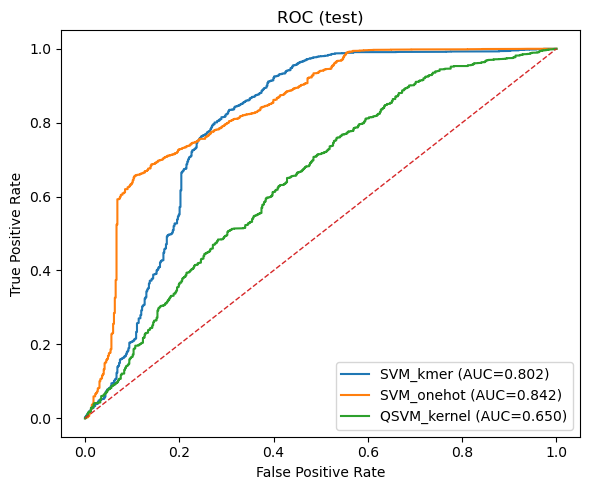

In [9]:
fig, ax = plt.subplots(figsize=(6,5))

def plot_roc(y_true, y_prob, label):
    try:
        y_true = np.asarray(y_true).reshape(-1)
        y_prob = np.asarray(y_prob).reshape(-1)
        if len(y_true) != len(y_prob):
            print(f"ROC for {label} skipped: length mismatch ({len(y_true)} vs {len(y_prob)})")
            return
        auc = roc_auc_score(y_true, y_prob)
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        ax.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")
    except Exception as e:
        print(f"ROC for {label} skipped: {e}")

if "p_te" in globals(): plot_roc(y[te], p_te, "SVM_kmer")
if "q_te" in globals(): plot_roc(y[te], q_te, "SVM_onehot")
if "r_te" in globals(): plot_roc(y[te], r_te, "QSVM_kernel")
if "s_te" in globals(): plot_roc(y[te], s_te, "VQC")

ax.plot([0,1], [0,1], "--", lw=1)
ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
ax.set_title("ROC (test)"); ax.legend()
plt.tight_layout(); plt.show()

# Cell 8 - confusion matrices

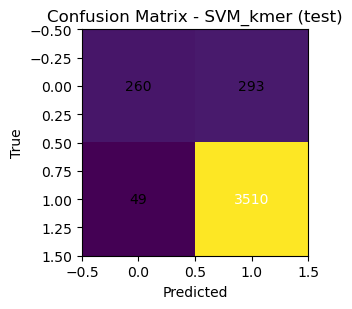

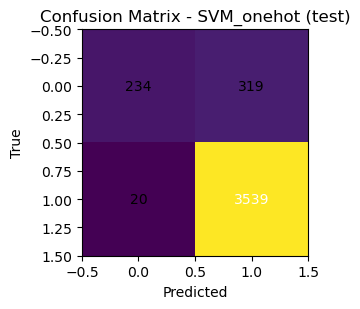

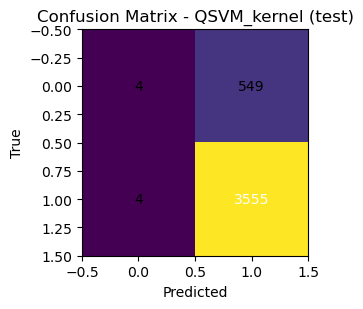

In [10]:
def _show_cm(name, cm):
    fig, ax = plt.subplots(figsize=(3.5, 3.2))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(f"Confusion Matrix - {name} (test)")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, int(v), ha="center", va="center",
                color="white" if im.norm(v) > 0.5 else "black")
    plt.tight_layout(); plt.show()

def _cm_aligned(y_true_full, prob_vec, thr):
    """
    Build a confusion matrix aligning y_true to the length of prob_vec.
    Handles cases where prob_vec is shorter (e.g., QSVM with truncated kernel).
    """
    n = len(prob_vec)
    y_true = y_true_full[:n]
    y_hat  = (prob_vec >= thr).astype(int)
    return confusion_matrix(y_true, y_hat, labels=[0, 1])

cms = []

# SVM (k-mer) - full test length
if "m1_te" in globals():
    cm1_te = _cm_aligned(y[te], p_te, m1_te["thr"])
    cms.append(("SVM_kmer", cm1_te))

# SVM (one-hot) - full test length
if "m2_te" in globals():
    cm2_te = _cm_aligned(y[te], q_te, m2_te["thr"])
    cms.append(("SVM_onehot", cm2_te))

# QSVM (precomputed kernel) - may be shorter than full test
if "m3_te" in globals():
    cm3_te = _cm_aligned(y[te], r_te, m3_te["thr"])
    cms.append(("QSVM_kernel", cm3_te))

# VQC - include only if present; may also be shorter
if "m4_te" in globals() and globals().get("s_te") is not None:
    cm4_te = _cm_aligned(y[te], s_te, m4_te["thr"])
    cms.append(("VQC", cm4_te))

# Show all available CMs
for name, cm in cms:
    _show_cm(name, cm)

# Save raw & normalized CM CSVs (aligned) for reproducibility
def _save_cm_csv(cm, out_csv, normalized=False):
    arr = cm.astype(np.float64)
    if normalized:
        rs = arr.sum(axis=1, keepdims=True)
        arr = np.divide(arr, np.where(rs == 0, 1, rs))
    df_cm = pd.DataFrame(arr, index=["true_0", "true_1"], columns=["pred_0", "pred_1"])
    df_cm.to_csv(out_csv, index=True)

for name, cm in cms:
    _save_cm_csv(cm, RESULTS / f"metrics/{name.lower()}_cm_test.csv", normalized=False)
    _save_cm_csv(cm, RESULTS / f"metrics/{name.lower()}_cm_test_norm.csv", normalized=True)

# Cell 9 - McNemar tests

In [11]:
import time
def _log(step, status, message):
    if 'J' in globals() and hasattr(J, "log"):
        J.log(step, status, message)
    else:
        print(f"[{status}] {step}: {message}")

# --- McNemar tests + robust logging (length-align and presence-check) ---
from math import fabs, exp

def mcnemar(y_true, yhat_a, yhat_b):
    n01 = int(((yhat_a == y_true) & (yhat_b != y_true)).sum())
    n10 = int(((yhat_a != y_true) & (yhat_b == y_true)).sum())
    # continuity-corrected chi^2
    chi2 = (abs(n01 - n10) - 1)**2 / (n01 + n10 + 1e-12)
    p = exp(-chi2/2)  # simple approx; for exact p, use binomial test
    return {"n01": n01, "n10": n10, "chi2": chi2, "p_approx": p}

# Collect available test probs + thresholds
models = []
if "p_te" in globals() and "m1_te" in globals():  # SVM_kmer
    models.append(("SVM_kmer", p_te, m1_te["thr"]))
if "q_te" in globals() and "m2_te" in globals():  # SVM_onehot
    models.append(("SVM_onehot", q_te, m2_te["thr"]))
if "r_te" in globals() and "m3_te" in globals():  # QSVM_kernel (may be shorter)
    models.append(("QSVM_kernel", r_te, m3_te["thr"]))
if "s_te" in globals() and globals().get("s_te") is not None and "m4_te" in globals():  # VQC (if present)
    models.append(("VQC", s_te, m4_te["thr"]))

# Nothing to do if we have fewer than 2 models
if len(models) < 2:
    _log("mcnemar", "warn", f"Need >=2 models for McNemar; found {len(models)}. Skipping.")
    stats = {}
else:
    # Determine a common aligned length across y[te] and all available prob arrays
    te_len = len(y[te])
    prob_lengths = [len(prob) for _, prob, _ in models]
    n = min([te_len] + prob_lengths)
    if n < te_len:
        _log("align", "warn",
              f"Aligned test length to n={n} to match shortest prob array "
              f"(labels={te_len}, probs={prob_lengths}).")

    y_true_aligned = y[te][:n].astype(int)

    # Build hard predictions at each model's best threshold
    preds = {name: (prob[:n] >= thr).astype(int) for name, prob, thr in models}

    # Prefer SVM_kmer as baseline; otherwise use the first model as baseline
    baseline_name = "SVM_kmer" if "SVM_kmer" in preds else models[0][0]

    # Compute McNemar vs baseline for each other model
    stats = {}
    for name in preds:
        if name == baseline_name:
            continue
        key = f"{name}_vs_{baseline_name}"
        stats[key] = mcnemar(y_true_aligned, preds[baseline_name], preds[name])

    # Persist stats
    (RESULTS/"stats").mkdir(parents=True, exist_ok=True)
    with open(RESULTS/"stats/mcnemar.json", "w", encoding="utf-8") as f:
        json.dump(stats, f, indent=2)

    # Show stats in notebook
    stats

# --- Save run journal (what worked, what didn't, why) ---
ts = time.strftime("%Y%m%d_%H%M%S")

# Ensure df exists for the "best test F1" summary; if not, build a minimal one from available *_te metrics
if "df" not in globals():
    rows_min = []
    if "m1_te" in globals(): rows_min.append(m1_te)
    if "m2_te" in globals(): rows_min.append(m2_te)
    if "m3_te" in globals(): rows_min.append(m3_te)
    if "m4_te" in globals(): rows_min.append(m4_te)
    df = pd.DataFrame(rows_min) if rows_min else pd.DataFrame(columns=["model","split","f1"])

try:
    best_row = df[df["split"]=="test"].sort_values("f1", ascending=False).iloc[0]
    _log("summary", "ok", f"Best test F1: {best_row['model']} ({best_row['f1']:.3f})")
except Exception:
    _log("summary", "warn", "Could not determine best test F1 (missing or empty df).")

if 'J' in globals() and hasattr(J, 'save'):
    J.save(RESULTS/"logs"/f"benchmark_analysis_{ts}")

    events = getattr(J, 'events', [])
    issues = [f"- [{e.get('step', '?')}] {e.get('message', '')}" for e in events if e.get('status') in ('warn', 'fail')]
    rollup = "No warnings or failures." if not issues else "Issues observed:\n" + "\n".join(issues)
    (Path(RESULTS/"logs"/f"benchmark_analysis_{ts}_summary.txt")).write_text(rollup, encoding="utf-8")
else:
    print("RunJournal not available; skipping log persistence.")

[OK] [summary] Best test F1: SVM_onehot (0.954)
